# Bonus: The `Cars Price` dataset revisited

🧑🏻‍🍳 During **`Machine Learning > 02 - Prepare the Dataset`**, we discovered that to run Machine Learning Algorithms properly, you need to feed them with ***cleaned datasets***.

<details>
    <summary>📝 <i>Reminders about the Data Preprocessing Workflow</i> 📝</summary>

1. 🧭 ***Exploratory Data Analysis***
2. 👥 Remove ***Duplicates***
3. 🤕 Impute or Remove ***Missing Values***
4. 🕵🏻‍♂️ Check for ***Outliers***
5. 📏 ***Scaling*** Numerical Features
6. 🏷 ***One-Hot-Encoder*** for Categorical Features 
7. 👻 ***Label-Encoder*** for a Categorical Target
8. 🍰 ***Feature Engineering*** will squeeze out better signals for your model to learn
feature instead_
9. 🍰 ***Target Engineering***: might be easier to predict a transformed target
    
10. ☠️ Not all features are our friends. Remove the "noisy" features using ***Feature Permutation*** (or ***VIF Analysis*** for Linear models)

<u> Additional Notes</u>    
    
- _Example of Feature Engineering: if you have the length and the width of a flat, you would maybe create the surface by multiplying the length by the width_

- _Example of Target Engineering: if you look to predict the price of a stock in the next day, it might be easier to predict the %increase rather than the absolute value. If you look at house prices, you may want to predict the logarithm of their values and then exponentiate the predictions_

- By "noisy" features, we mean :
    - either a feature that doesn't bring anything to the prediction in a sense that when you shuffle this feature, it doesn't affect the performance of your model
    - or a feature that is built using other features (strong linear relationship)
    
</details>

🚗 We had  already worked on a simplified version of the *Cars' Price* dataset. 

🎯 The goal of this recap is to build an optimal pipeline to ***predict the price of cars according to their specificities***:

1. We will need a *Preprocessing Pipeline*...
2. ... that we can *chain with a Scikit-Learn Estimator*
3. And go further by:
    - running a *FeaturePermutation*
    - optimizing the hyperparameters with a *GridSearchCV* or a *RandomizedSearchCV*

In [1]:
# DATA MANIPULATION
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None) # Show all columns of a Pandas DataFrame

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# STATISTICS
from statsmodels.graphics.gofplots import qqplot
# This function plots your sample distribution against a Normal distribution, 
# to check whether your sample is normally distributed or not

## (1) The dataset

In [2]:
cars = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_cars_dataset_26_columns.csv")
cars.drop(columns = ['car_ID'], inplace = True)
cars.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### (1.1) Basic Info

❓ How many cars do we have ❓

In [10]:
# YOUR CODE HERE
cars.CarName.value_counts()

toyota corona           6
toyota corolla          6
peugeot 504             6
subaru dl               4
mitsubishi mirage g4    3
                       ..
mazda glc 4             1
mazda rx2 coupe         1
maxda glc deluxe        1
maxda rx3               1
volvo 246               1
Name: CarName, Length: 147, dtype: int64

❓ Inspect the types of your columns ❓

In [11]:
# YOUR CODE HERE
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

### (1.2) Prerequisites

#### (1.2.1) Anomalies in the dataset

❓ If you carefully look at the columns with *object*, which columns could/should be converted to numerical columns  ❓ 

👉 Convert them.

<details>
    <summary><i>Hint</i></summary>

* The _cylindernumber_ clearly needs to be converted to a numerical feature
* As for the _doornumber_, it is up to you but we think that we can keep it as a categorical feature since most of the cars have either two or four doors, not one, three or five!
</details>


In [12]:
# YOUR CODE HERE
cars["cylindernumber"] = cars["cylindernumber"].map({"four":4,
                                                 "six":6,
                                                 "five":5,
                                                 "eight":8,
                                                 "two":2,
                                                 "twelve":12,
                                                 "three":3})

#### (1.2.2) Removing duplicates 

❓ How many duplicated rows do we have in this dataset (if so, get rid of any duplicated row) ❓

In [18]:
# YOUR CODE HERE
print(f"number of duplicated rows = {cars.duplicated().sum()}")
print("-"*50)

print(f"cars' shape before removing duplicates = {cars.shape}")
print("-"*50)

cars.drop_duplicates(inplace = True)
print(f"cars' shape after removing duplicates = {cars.shape}")

number of duplicated rows = 0
--------------------------------------------------
cars' shape before removing duplicates = (205, 25)
--------------------------------------------------
cars' shape after removing duplicates = (205, 25)


#### (1.2.3) Handling Missing Values

❓ How many NaN do we have ❓

In [19]:
# YOUR CODE HERE
cars.isna().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

<details>
    <summary><i>Answer</i></summary>

* No NaN here, it's a miracle 😇 
* If you have more than 30% of missing values in a row/column, drop the row/column 🚮
* Otherwise, you could use a *SimpleImputer* or a *KNN Imputer* to impute these missing values 😉
    
</details>

### (1.3) Having a glance at your target (`cars' price`)

❓ How does your target look like in terms of _Distribution_, _Outliers_, _Gaussianity_  ❓

<details>
    <summary><i>Code answer</i></summary>

Save this block of code for future use ;)
```python
variable = 'price'
y = cars[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = cars, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = cars, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
qqplot(cars[f"{variable}"],line='s',ax=ax[2]);    
```
    
- The histogram with the estimated density shows us that ***the distribution of the prices is quite skewed and non-Gaussian***
- The boxplot indicates some potential outliers. You should check the values, and see, that these are just more expensive cars. But none of the values seems to be completely out of range, like a false measurement et cetera...! #BusinessKnowledge 
- The QQ-plot is another proof that the distribution of the prices is not Gaussian:
    - Remember that the scatter dots of your signal should match the $ y = x $ (45-degree line) closely, if the signal is Gaussian distributed.

</details>       

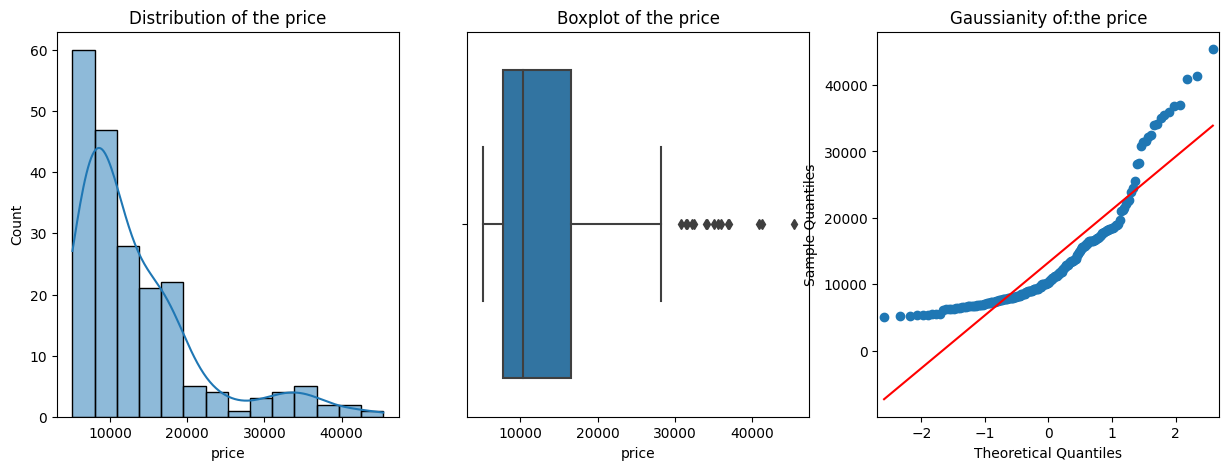

In [20]:
# YOUR CODE HERE
variable = 'price'
y = cars[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = cars, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = cars, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
qqplot(cars[f"{variable}"],line='s',ax=ax[2]);

## (2) Preprocessing the features with a Pipeline

🎬 Great, you have an overview of how the cars are distributed. 

🔥 It's time to build a _preprocessing pipeline_ that we will, in a humble way, call the _preprocessor_.

<details>
    <summary>🤔 How to deal with the <i>CarName</i> to predict the price of a car ? </summary>
    
1. You could extract the `CarBrand` using *Regex* techniques
2. As we haven't studied yet how to handle ***textual data*** (cf. ***Machine Learning > Natural Language Processing***), let's ignore the `CarName` to predict the price for the moment.
    
</details>

In [21]:
X = cars.drop(columns = ["price", "CarName"])

In [22]:
# PIPELINE AND COLUMNTRANSFORMER
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")  

# IMPUTERS
from sklearn.impute import SimpleImputer

# SCALERS
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# ENCODER
from sklearn.preprocessing import OneHotEncoder

### (2.1) Numerical Pipeline

❓ Store the numerical features in a `X_num` variable ❓

In [23]:
# YOUR CODE HERE
X_num = X.select_dtypes(exclude = ['object'])
X_num.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27
1,3,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27
2,1,94.5,171.2,65.5,52.4,2823,6,152,2.68,3.47,9.0,154,5000,19,26
3,2,99.8,176.6,66.2,54.3,2337,4,109,3.19,3.40,10.0,102,5500,24,30
4,2,99.4,176.6,66.4,54.3,2824,5,136,3.19,3.40,8.0,115,5500,18,22


❓ Create a `num_transformer` pipeline to deal with numerical features ❓
<details>
    <summary>📚 <i>Reminder about scalers</i></summary>
    
👉 Great article <a href="https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02">Scale, Standardize or Normalize with Scikit-Learn</a> written by Jeff Hale    

</details>

> YOUR ANSWER HERE

### (2.2) Categorical Pipeline

❓ Store the categorical features in a variable called `cars_cat` ❓

In [24]:
# YOUR CODE HERE
cars_cat = X.select_dtypes(exclude = ['int64', 'float64'])
cars_cat

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,fuelsystem
0,gas,std,two,convertible,rwd,front,dohc,mpfi
1,gas,std,two,convertible,rwd,front,dohc,mpfi
2,gas,std,two,hatchback,rwd,front,ohcv,mpfi
3,gas,std,four,sedan,fwd,front,ohc,mpfi
4,gas,std,four,sedan,4wd,front,ohc,mpfi
...,...,...,...,...,...,...,...,...
200,gas,std,four,sedan,rwd,front,ohc,mpfi
201,gas,turbo,four,sedan,rwd,front,ohc,mpfi
202,gas,std,four,sedan,rwd,front,ohcv,mpfi
203,diesel,turbo,four,sedan,rwd,front,ohc,idi


❓ Check how many columns you would end up with, if you decide to One Hot Encode them all. Is it a reasonable number ❓




In [ ]:
# YOUR CODE HERE


❓ Create a `cat_transformer` pipeline to deal with categorical features ❓

In [ ]:
# YOUR CODE HERE

### (2.3) Full Preprocessor

❓ Create the `preprocessor` which combines the `num_transformer` and the `cat_transformer`  ❓

In [ ]:
# YOUR CODE HERE

## (3) Full pipeline with a Regression Model

🚀 We can now try different regression model pipelined with the preprocessor 🚀

❓ Create a function that will create a Pipeline with the `preprocessor` and a regression model ❓

In [ ]:
# YOUR CODE HERE

❓ Testing different pipelined regression models ❓


🤓 Do not forget to refer to [Scikit-Learn - Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [ ]:
# YOUR CODE HERE

❓ Evaluating the pipelined models: which pipelined regressor performed the best ❓

In [ ]:
# YOUR CODE HERE

🏁 Congratulations!

💾 Don't forget to git add/commit/push your notebook...

🚀 You are now a master at `Pipeline` and `ColumnTransformer` !